# Análise de Tendências Temáticas — WIT
**Questões de Pesquisa:**
- QP1: Quais áreas temáticas são mais recorrentes nos trabalhos aceitos no WIT ao longo de sua história?
- QP2: Como essas áreas temáticas evoluíram ao longo dos anos?
- QP3: Existem tendências de crescimento, estabilidade ou declínio em determinados temas?
- QP4: De que forma o uso de técnicas de ML contribui para a análise da evolução temática da produção científica do WIT?

## Importações e Pré-Processamento

In [4]:
pip install langdetect seaborn bertopic sentence-transformers umap-learn hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=92f1aa14bc29fa2ee1beac5da257d49b0956e4e499b033f7c0ad532f996dcadc
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import ast

from langdetect import detect
from collections import Counter
from scipy import stats

In [6]:
df = pd.read_csv('pre_processamento_abstract.csv')
df.head()

,Unnamed: 0,edicao,categoria,titulo,autores,abstract,url,ano,id_artigo,titulo_pre_processado,abstract_pre_processado
0,0,2025: Anais do XIX Women in Information Techno...,Artigos de Pesquisa,Inclusão de Mulheres na Área de Cibersegurança...,Maristela Holanda (UnB); Adrielly Lima (UnB); ...,A baixa participação profissional das mulheres...,https://sol.sbc.org.br/index.php/wit/article/v...,2025,1,"['inclusao', 'mulher', 'areo', 'ciberseguranca...","['baixo', 'participacao', 'profissional', 'mul..."
1,1,2025: Anais do XIX Women in Information Techno...,Artigos de Pesquisa,Presença de mulheres na Engenharia: Um estudo ...,Marinêz V. de M. Werneck Magalhães (CEFET-MG);...,Este estudo analisou a representatividade de m...,https://sol.sbc.org.br/index.php/wit/article/v...,2025,2,"['presenca', 'mulher', 'engenharia', 'estudo',...","['estudo', 'analisar', 'representatividade', '..."
2,2,2025: Anais do XIX Women in Information Techno...,Artigos de Pesquisa,Interseccionalidade e Tecnologia: Um Mapeament...,Karolyne Rodrigues (IFCE); Rayane Silva Duarte...,O presente estudo consiste em um Mapeamento Si...,https://sol.sbc.org.br/index.php/wit/article/v...,2025,3,"['interseccionalidade', 'tecnologia', 'mapeame...","['presente', 'estudo', 'consistir', 'mapeament..."
3,3,2025: Anais do XIX Women in Information Techno...,Artigos de Pesquisa,Investigando o Ingresso e a Permanência Femini...,Lívia Evily de A. Rocha (UESB); Ana Carolina X...,Este artigo analisa a participação feminina no...,https://sol.sbc.org.br/index.php/wit/article/v...,2025,4,"['investigar', 'ingresso', 'permanencia', 'fem...","['artigo', 'analisar', 'participacao', 'femini..."
4,4,2025: Anais do XIX Women in Information Techno...,Artigos de Pesquisa,Conectando Mulheres à STEM: Um Panorama dos Ev...,Ana Clara Ribeiro Rodrigues da Cunha (IFTM); L...,A baixa representatividade feminina na Tecnolo...,https://sol.sbc.org.br/index.php/wit/article/v...,2025,5,"['conectar', 'mulher', 'stir', 'panorama', 'ev...","['baixo', 'representatividade', 'feminino', 't..."


In [7]:
def detect_language(text):
    try:
        return detect(str(text))
    except:
        return 'unknown'

df['idioma_titulo'] = df['titulo'].apply(detect_language)
df['idioma_abstract'] = df['abstract'].apply(detect_language)

In [13]:
df["abstract_pre_processado"] = df["abstract_pre_processado"].apply(ast.literal_eval)

vocabulario = set()
for tokens in df["abstract_pre_processado"]:
    vocabulario.update(tokens)

print("Tamanho do vocabulário:", len(vocabulario))

Tamanho do vocabulário: 3825


In [14]:
# Corpus WIT é integralmente em português — usamos todos os registros
df_filtered = df.copy()
print(f"Total de abstracts: {len(df_filtered)}")
print(f"Intervalo de anos: {df_filtered['ano'].min()} – {df_filtered['ano'].max()}")
print(f"Tokens únicos no vocabulário: {len(vocabulario)}")

Total de abstracts: 417
Intervalo de anos: 2016 – 2025
Tokens únicos no vocabulário: 3825


## TF-IDF + K-Means Clustering

### Imports e Vetorização

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# Reconstrói texto a partir dos tokens
texts_tfidf = df_filtered["abstract_pre_processado"].apply(lambda x: " ".join(x))

# TF-IDF
tfidf = TfidfVectorizer(min_df=2, max_df=0.9)
X_tfidf = tfidf.fit_transform(texts_tfidf)

# Redução de dimensionalidade (LSA)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print(f"Matriz TF-IDF: {X_tfidf.shape}")
print(f"Matriz reduzida (LSA): {X_reduced.shape}")

Matriz TF-IDF: (417, 1724)
Matriz reduzida (LSA): (417, 100)


### Escolha do Número de Clusters (Avaliação Quantitativa)

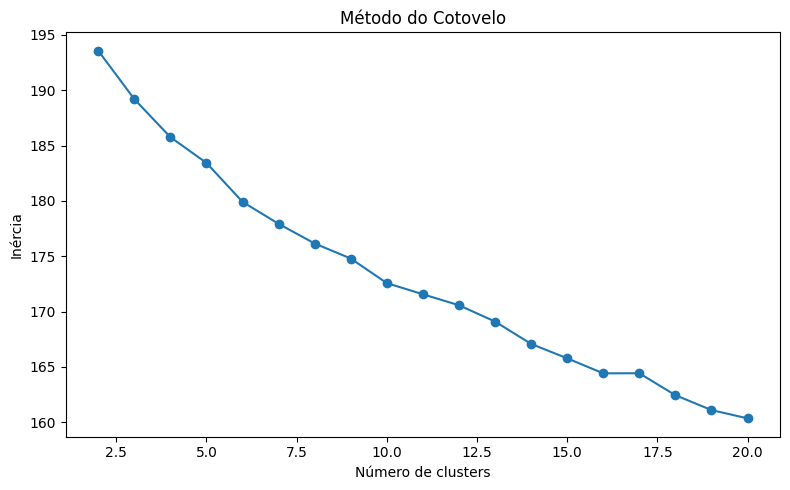

In [16]:
# Método do Cotovelo

inertias = []
k_range = range(2, 21)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.tight_layout()
plt.show()

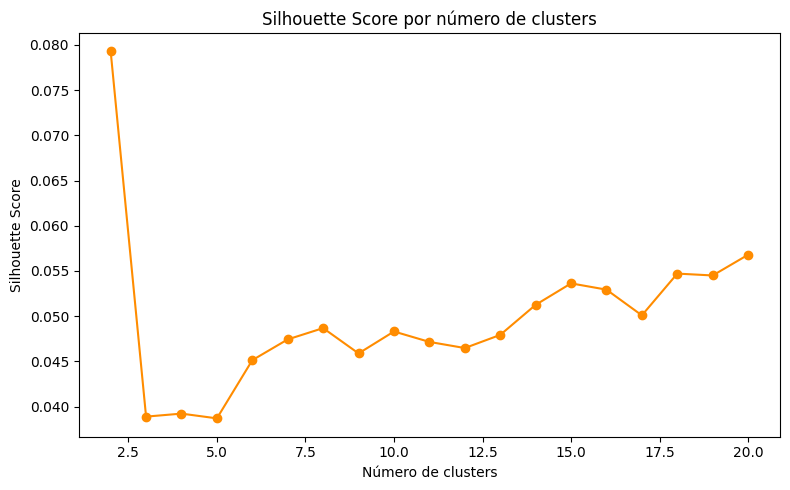

In [17]:
# Silhouette Score
silhouette_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='darkorange')
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score por número de clusters")
plt.tight_layout()
plt.show()

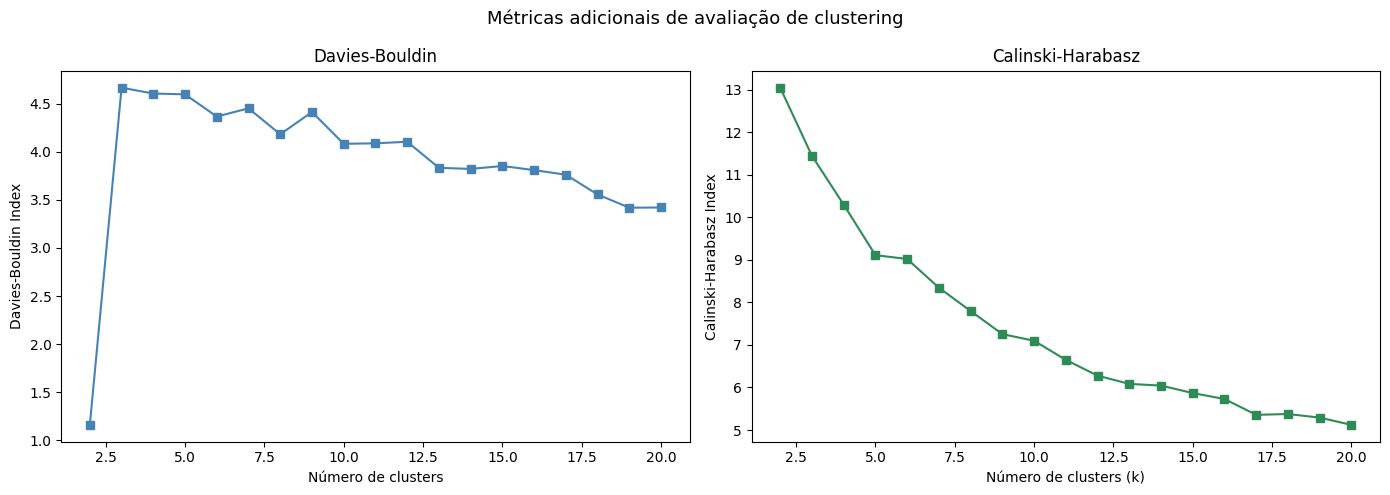

 k  Silhouette  Davies-Bouldin  Calinski-Harabasz
 2    0.079312        1.158973          13.042523
 3    0.038889        4.668438          11.441658
 4    0.039222        4.607776          10.294948
 5    0.038697        4.599093           9.108399
 6    0.045135        4.367940           9.017913
 7    0.047431        4.453488           8.343424
 8    0.048680        4.183692           7.795840
 9    0.045881        4.415347           7.253142
10    0.048307        4.084509           7.096725
11    0.047154        4.089506           6.647450
12    0.046475        4.105688           6.277137
13    0.047928        3.834426           6.083256
14    0.051253        3.823149           6.043772
15    0.053629        3.853334           5.868148
16    0.052935        3.810339           5.728541
17    0.050091        3.763046           5.356007
18    0.054710        3.556755           5.375859
19    0.054503        3.419244           5.291177
20    0.056797        3.421600           5.120975


In [18]:
db_scores = []
ch_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    db_scores.append(davies_bouldin_score(X_reduced, labels))
    ch_scores.append(calinski_harabasz_score(X_reduced, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Davies-Bouldin: quanto MENOR, melhor separação entre clusters
axes[0].plot(k_range, db_scores, marker='s', color='steelblue')
axes[0].set_xlabel("Número de clusters")
axes[0].set_ylabel("Davies-Bouldin Index")
axes[0].set_title("Davies-Bouldin")

# Calinski-Harabasz: quanto MAIOR, melhor separação entre clusters
axes[1].plot(k_range, ch_scores, marker='s', color='seagreen')
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Calinski-Harabasz Index")
axes[1].set_title("Calinski-Harabasz")

plt.suptitle("Métricas adicionais de avaliação de clustering", fontsize=13)
plt.tight_layout()
plt.show()

# Tabela resumo
metricas_df = pd.DataFrame({
    'k': list(k_range),
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': db_scores,
    'Calinski-Harabasz': ch_scores
})
print(metricas_df.to_string(index=False))

### Modelo Final — Clustering

In [19]:
# Ajuste K de acordo com as métricas
K = 7

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_filtered["topic_tfidf"] = kmeans.fit_predict(X_reduced)

# Top termos por cluster
terms = tfidf.get_feature_names_out()
centroids_original = svd.inverse_transform(kmeans.cluster_centers_)

def top_terms_per_cluster(centroids, terms, top_n=10):
    cluster_terms = {}
    for i, centroid in enumerate(centroids):
        top_indices = np.argsort(centroid)[::-1][:top_n]
        cluster_terms[i] = [terms[idx] for idx in top_indices]
    return cluster_terms

cluster_keywords = top_terms_per_cluster(centroids_original, terms, top_n=10)

print("Top termos por cluster:")
for cluster, keywords in cluster_keywords.items():
    print(f"  Cluster {cluster}: {', '.join(keywords)}")

Top termos por cluster:
  Cluster 0: ensino, oficina, medio, projeto, aluna, computacao, escola, experiencia, estudante, menina
  Cluster 1: projeto, mulher, feminino, acoes, digital, participacao, computacao, iniciativa, curso, area
  Cluster 2: programacao, mulher, areo, curso, computacao, tecnologia, apresentar, competicoes, feminino, artigo
  Cluster 3: jogo, mulher, feminino, historia, digital, personagem, desenvolvimento, computacao, trabalho, ensino
  Cluster 4: brasileiro, computacao, mulher, dado, genero, analise, artigo, evento, iniciativa, estudo
  Cluster 5: curso, mulher, computacao, genero, ciencia, analise, areo, trabalho, estudo, profissional
  Cluster 6: the, and, thi, gender, women, female, that, with, are, science


In [20]:
# Nomeação manual dos clusters com base nas top keywords

nomes_clusters_tfidf = {
    0: "Cluster 0",
    1: "Cluster 1",
    2: "Cluster 2",
    3: "Cluster 3",
    4: "Cluster 4",
    5: "Cluster 5",
    6: "Cluster 6",
}

df_filtered["tema_tfidf"] = df_filtered["topic_tfidf"].map(nomes_clusters_tfidf)
print("Distribuição por tema:")
print(df_filtered["tema_tfidf"].value_counts())

Distribuição por tema:
tema_tfidf
Cluster 5    100
Cluster 1     98
Cluster 0     72
Cluster 2     56
Cluster 4     53
Cluster 3     27
Cluster 6     11
Name: count, dtype: int64


### Visualizações TF-IDF

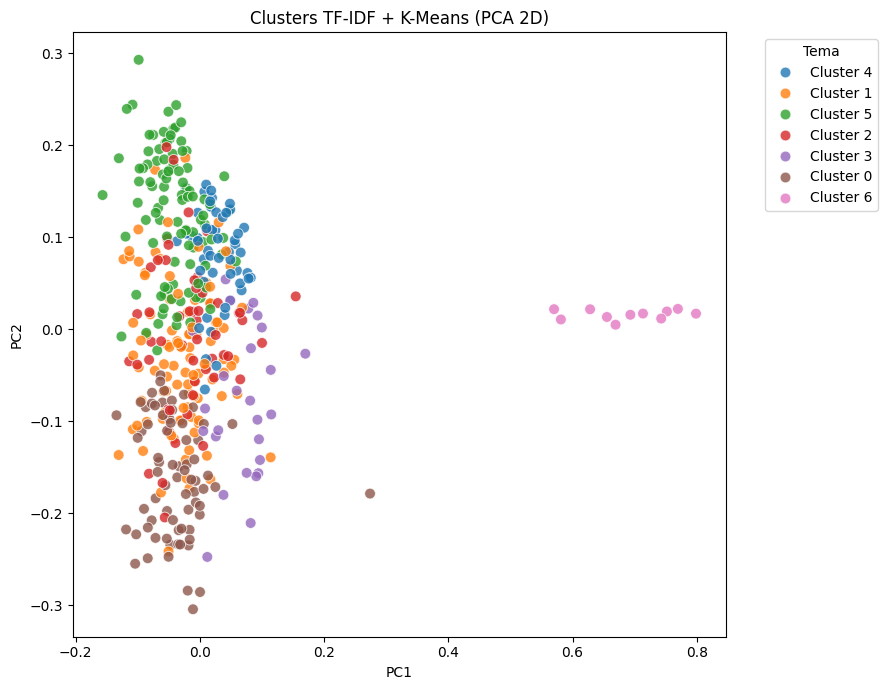

In [21]:
# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_reduced)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_filtered["tema_tfidf"],
    palette="tab10",
    s=60,
    alpha=0.8
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters TF-IDF + K-Means (PCA 2D)")
plt.legend(title="Tema", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

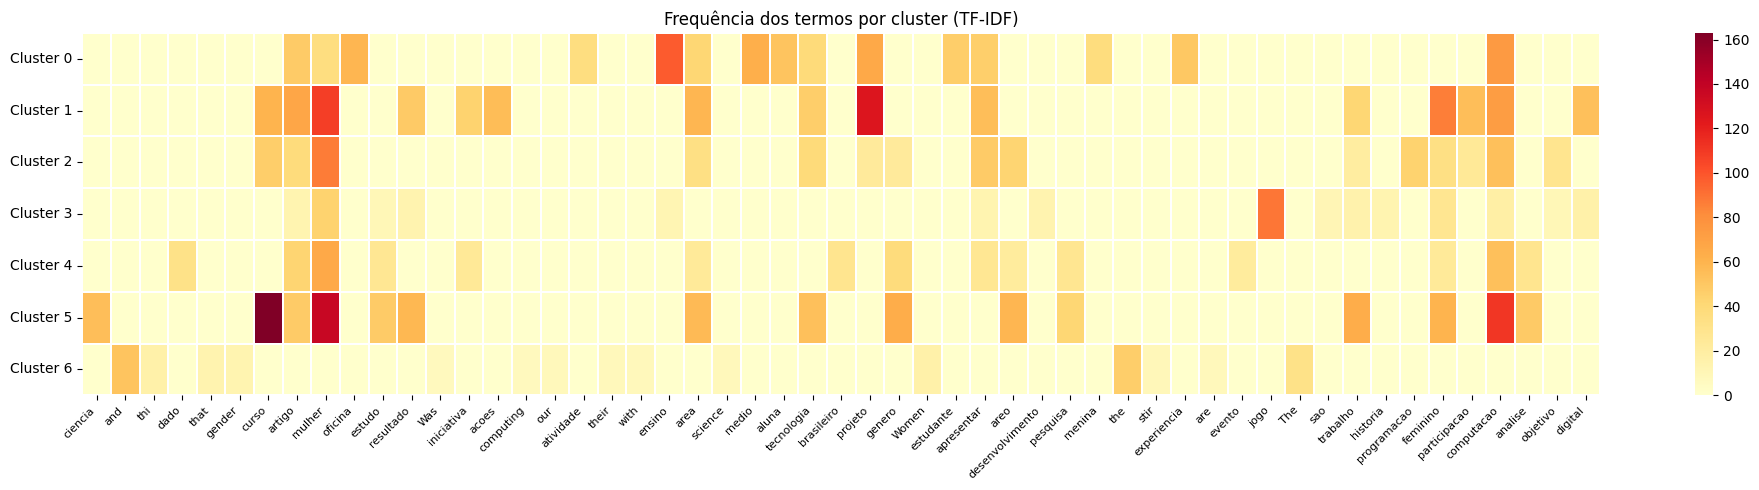

In [22]:
# Heatmap de frequência dos top termos por cluster - Útil para visualizar sobreposição temática entre clusters
top_terms_all = []
for cluster in sorted(df_filtered["topic_tfidf"].unique()):
    mask = df_filtered["topic_tfidf"] == cluster
    freq = Counter([t for tokens in df_filtered[mask]["abstract_pre_processado"] for t in tokens])
    top_terms_all.append({t: freq[t] for t, _ in freq.most_common(15)})

all_terms_heatmap = list(set(t for d in top_terms_all for t in d))
matrix = pd.DataFrame(
    [{t: d.get(t, 0) for t in all_terms_heatmap} for d in top_terms_all]
)
matrix.index = [nomes_clusters_tfidf.get(i, f"Cluster {i}") for i in sorted(df_filtered["topic_tfidf"].unique())]

plt.figure(figsize=(20, 5))
sns.heatmap(matrix, cmap="YlOrRd", linewidths=0.3, annot=False)
plt.title("Frequência dos termos por cluster (TF-IDF)")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

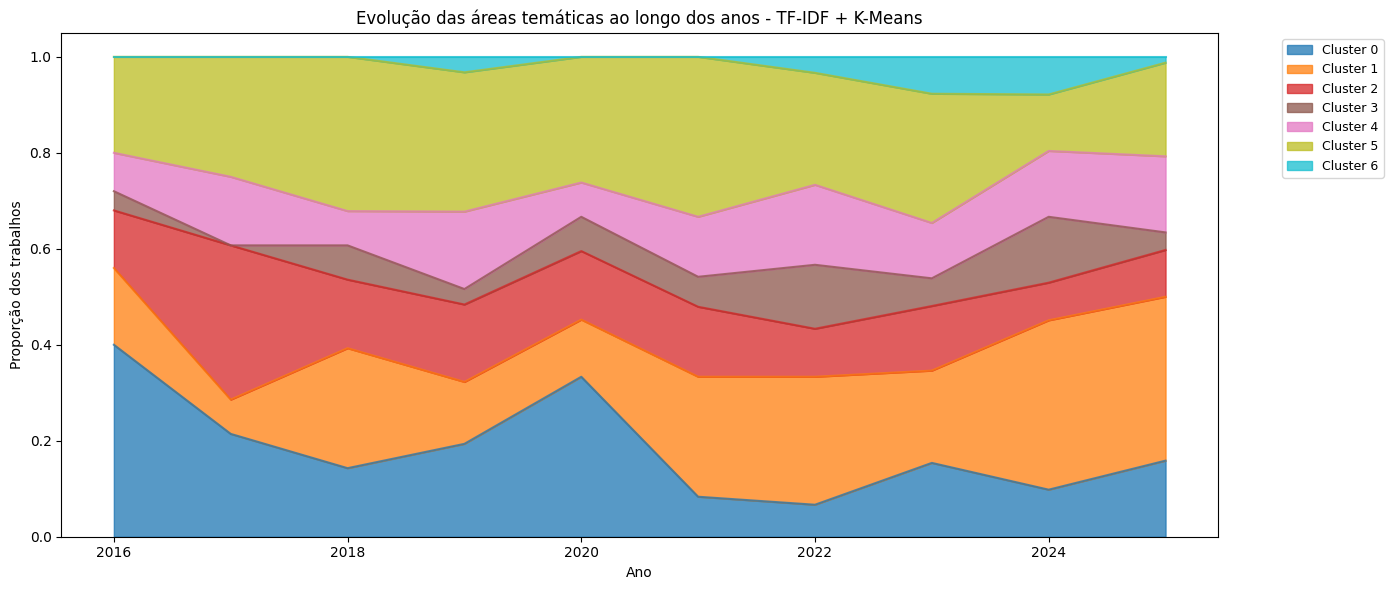

In [23]:
# Evolução temporal das áreas temáticas
temporal_tfidf = df_filtered.groupby(["ano", "topic_tfidf"]).size().unstack(fill_value=0)
temporal_tfidf.columns = [nomes_clusters_tfidf.get(c, f"Cluster {c}") for c in temporal_tfidf.columns]
temporal_prop_tfidf = temporal_tfidf.div(temporal_tfidf.sum(axis=1), axis=0)

temporal_prop_tfidf.plot(
    kind="area",
    stacked=True,
    figsize=(14, 6),
    colormap="tab10",
    alpha=0.75
)
plt.title("Evolução das áreas temáticas ao longo dos anos - TF-IDF + K-Means")
plt.xlabel("Ano")
plt.ylabel("Proporção dos trabalhos")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

In [24]:
# Abstracts mais representativos por cluster

def abstracts_mais_representativos(cluster_id, df_filtered, X_reduced, kmeans, n=3):
    mask = (df_filtered["topic_tfidf"] == cluster_id).values
    centroid = kmeans.cluster_centers_[cluster_id]
    X_cluster = X_reduced[mask]
    sims = cosine_similarity([centroid], X_cluster)[0]
    top = np.argsort(sims)[::-1][:n]
    return df_filtered[mask].iloc[top][["titulo", "ano", "abstract"]]

for cluster_id in sorted(df_filtered["topic_tfidf"].unique()):
    nome = nomes_clusters_tfidf.get(cluster_id, f"Cluster {cluster_id}")
    print(f"\n{'='*60}")
    print(f"Cluster {cluster_id} — {nome}")
    print(f"Keywords: {', '.join(cluster_keywords[cluster_id])}")
    print(f"{'='*60}")
    rep = abstracts_mais_representativos(cluster_id, df_filtered, X_reduced, kmeans, n=2)
    for _, row in rep.iterrows():
        print(f"[{row['ano']}] {row['titulo']}")


Cluster 0 — Cluster 0
Keywords: ensino, oficina, medio, projeto, aluna, computacao, escola, experiencia, estudante, menina
[2018] Mulheres de Ferro: Relato de Prática Utilizando Arduíno com Alunas do Ensino Médio em uma Escola Pública
[2016] Curto-Circuito na Escola

Cluster 1 — Cluster 1
Keywords: projeto, mulher, feminino, acoes, digital, participacao, computacao, iniciativa, curso, area
[2025] TechManas: Estimulando a igualdade de gênero e o interesse de mulheres e meninas da Região do Lago de Tucuruí nas tecnologias
[2025] O Impacto dos Projetos de Extensão Femininos: Fortalecendo a Presença Feminina nas Engenharias e Tecnologias

Cluster 2 — Cluster 2
Keywords: programacao, mulher, areo, curso, computacao, tecnologia, apresentar, competicoes, feminino, artigo
[2020] Estudo sobre o empoderamento feminino através de comunidades de tecnologia
[2016] Cunhantã Digital: programa de incentivo à participação de mulheres da região amazônica na Computação e áreas afins

Cluster 3 — Cluster

## BERTopic

### Imports e Configuração

In [25]:
import subprocess
subprocess.run(["python", "-m", "spacy", "download", "pt_core_news_sm"])

CompletedProcess(args=['python', '-m', 'spacy', 'download', 'pt_core_news_sm'], returncode=0)

In [26]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [39]:
# Textos originais (abstracts completos)
texts_bert = df_filtered["abstract"].astype(str).tolist()

# Embeddings multilíngues
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Stopwords em português via spaCy
nlp = spacy.load("pt_core_news_sm")
stopwords_pt = list(nlp.Defaults.stop_words)

# Vectorizer com stopwords
vectorizer_model = CountVectorizer(stop_words=stopwords_pt, min_df=2)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [52]:
from hdbscan import HDBSCAN
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,      # padrão é 15 — menor = clusters mais locais
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=15,  # era 10 via min_topic_size
    min_samples=5,       # mais tolerante a pontos isolados
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts_bert)
df_filtered["topic_bertopic"] = topics

2026-02-17 19:44:38,440 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2026-02-17 19:44:38,802 - BERTopic - Embedding - Completed ✓
2026-02-17 19:44:38,803 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-17 19:44:39,882 - BERTopic - Dimensionality - Completed ✓
2026-02-17 19:44:39,883 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-17 19:44:39,897 - BERTopic - Cluster - Completed ✓
2026-02-17 19:44:39,900 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-17 19:44:39,941 - BERTopic - Representation - Completed ✓


### Avaliação BERTopic

In [53]:
# Proporção de outliers (tópico -1)

outlier_ratio = (df_filtered["topic_bertopic"] == -1).mean()
n_topicos = len(set(topics)) - (1 if -1 in topics else 0)

print(f"Número de tópicos encontrados: {n_topicos}")
print(f"Proporção de outliers (tópico -1): {outlier_ratio:.2%}")
print()
print("Informações por tópico:")
print(topic_model.get_topic_info().to_string(index=False))

Número de tópicos encontrados: 9
Proporção de outliers (tópico -1): 46.04%

Informações por tópico:
 Topic  Count                                       Name                                                                                             Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Visualizações BERTopic

In [43]:
# Top palavras por tópico
topic_model.visualize_barchart(top_n_topics=32)

In [44]:
# Heatmap de similaridade entre tópicos
topic_model.visualize_heatmap()

In [46]:
# Mapa 2D dos tópicos (distância semântica)
topic_model.visualize_topics()

In [47]:
# Tópicos ao longo do tempo
topics_over_time = topic_model.topics_over_time(
    docs=texts_bert,
    timestamps=df_filtered["ano"].tolist(),
    topics=topics
)

topic_model.visualize_topics_over_time(topics_over_time)

10it [00:00, 47.07it/s]


## Análise de Tendências e Comparação de Abordagens

### Regressão Linear por Tema — Detectando Crescimento/Declínio (QP3)

In [48]:
# Regressão linear na proporção anual de cada cluster
resultados_tendencia = []

for cluster in temporal_prop_tfidf.columns:
    anos = temporal_prop_tfidf.index.astype(int).values
    prop = temporal_prop_tfidf[cluster].values

    if len(anos) < 3:
        continue

    slope, intercept, r_value, p_value, std_err = stats.linregress(anos, prop)

    if p_value < 0.05:
        tendencia = "📈 Crescimento" if slope > 0 else "📉 Declínio"
    else:
        tendencia = "➡️ Estável"

    resultados_tendencia.append({
        "Tema": cluster,
        "Tendência": tendencia,
        "Slope": round(slope, 5),
        "R²": round(r_value**2, 3),
        "p-valor": round(p_value, 4)
    })

tendencias_df = pd.DataFrame(resultados_tendencia).sort_values("Slope", ascending=False)
print(tendencias_df.to_string(index=False))

     Tema     Tendência    Slope    R²  p-valor
Cluster 1 📈 Crescimento  0.02339 0.558   0.0130
Cluster 3    ➡️ Estável  0.00700 0.242   0.1491
Cluster 6    ➡️ Estável  0.00634 0.372   0.0614
Cluster 4    ➡️ Estável  0.00580 0.223   0.1685
Cluster 5    ➡️ Estável -0.00807 0.143   0.2804
Cluster 2    ➡️ Estável -0.01288 0.335   0.0795
Cluster 0    ➡️ Estável -0.02159 0.368   0.0629


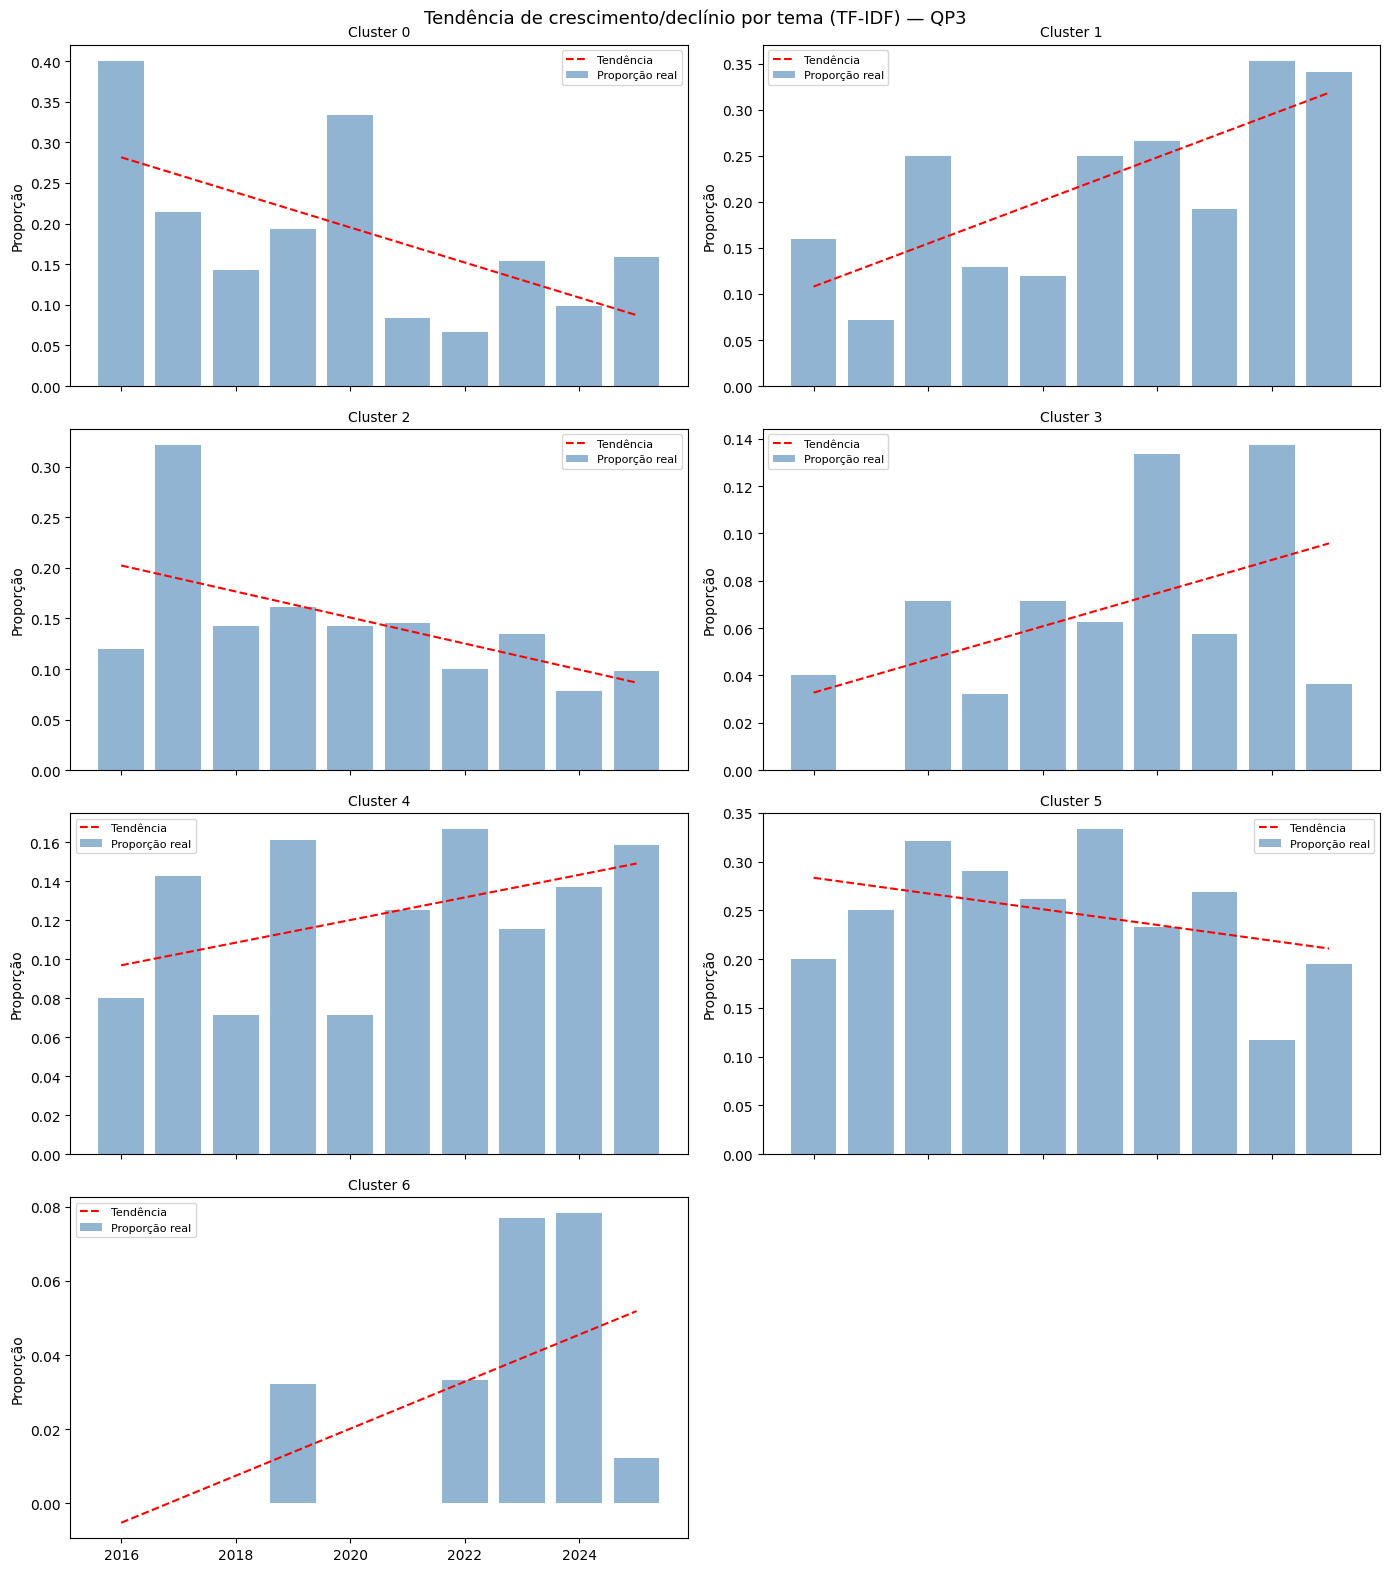

In [49]:
# Visualização: proporção por tema com linha de tendência
fig, axes = plt.subplots(
    nrows=(len(temporal_prop_tfidf.columns) + 1) // 2,
    ncols=2,
    figsize=(14, 4 * ((len(temporal_prop_tfidf.columns) + 1) // 2)),
    sharex=True
)
axes = axes.flatten()

for i, tema in enumerate(temporal_prop_tfidf.columns):
    anos = temporal_prop_tfidf.index.astype(int).values
    prop = temporal_prop_tfidf[tema].values
    slope, intercept, *_ = stats.linregress(anos, prop)

    axes[i].bar(anos, prop, color="steelblue", alpha=0.6, label="Proporção real")
    axes[i].plot(anos, slope * anos + intercept, color="red", linestyle="--", label="Tendência")
    axes[i].set_title(tema, fontsize=10)
    axes[i].set_ylabel("Proporção")
    axes[i].legend(fontsize=8)

# Oculta eixos sobrando
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Tendência de crescimento/declínio por tema (TF-IDF) — QP3", fontsize=13)
plt.tight_layout()
plt.show()

### Comparação entre Abordagens — TF-IDF vs BERTopic (QP4)

In [50]:
# Tabela comparativa entre os dois métodos

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Remove outliers do BERTopic para comparação justa
mask_valid = df_filtered["topic_bertopic"] != -1

ari = adjusted_rand_score(
    df_filtered[mask_valid]["topic_tfidf"],
    df_filtered[mask_valid]["topic_bertopic"]
)
nmi = normalized_mutual_info_score(
    df_filtered[mask_valid]["topic_tfidf"],
    df_filtered[mask_valid]["topic_bertopic"]
)

print("Concordância entre TF-IDF + KMeans e BERTopic:")
print(f"  Adjusted Rand Index (ARI): {ari:.3f}  (1.0 = concordância total, 0.0 = aleatório)")
print(f"  Normalized Mutual Info  (NMI): {nmi:.3f}  (1.0 = concordância total)")
print()
print("Nota: Valores baixos indicam que os métodos encontram estruturas diferentes.")
print("Para temas convergentes, isso é esperado — use os dois como triangulação.")

# Tabela resumo das abordagens
resumo = pd.DataFrame({
    "Critério": [
        "Tipo de representação",
        "Método de agrupamento",
        "Número de tópicos",
        "Trata outliers",
        "Sensível à semântica",
        "Interpretabilidade",
        "Custo computacional"
    ],
    "TF-IDF + KMeans": [
        "Frequência de termos",
        "Particionamento (K fixo)",
        f"{K} (definido)",
        "Não",
        "Baixa",
        "Alta (keywords diretas)",
        "Baixo"
    ],
    "BERTopic": [
        "Embeddings contextuais",
        "Densidade (HDBSCAN)",
        f"{n_topicos} (automático)",
        "Sim (tópico -1)",
        "Alta",
        "Média (requer análise)",
        "Alto"
    ]
})

print("\n" + resumo.to_string(index=False))

Concordância entre TF-IDF + KMeans e BERTopic:
  Adjusted Rand Index (ARI): 0.112  (1.0 = concordância total, 0.0 = aleatório)
  Normalized Mutual Info  (NMI): 0.340  (1.0 = concordância total)

Nota: Valores baixos indicam que os métodos encontram estruturas diferentes.
Para temas convergentes, isso é esperado — use os dois como triangulação.

             Critério          TF-IDF + KMeans               BERTopic
Tipo de representação     Frequência de termos Embeddings contextuais
Método de agrupamento Particionamento (K fixo)    Densidade (HDBSCAN)
    Número de tópicos             7 (definido)        32 (automático)
       Trata outliers                      Não        Sim (tópico -1)
 Sensível à semântica                    Baixa                   Alta
   Interpretabilidade  Alta (keywords diretas) Média (requer análise)
  Custo computacional                    Baixo                   Alto


In [51]:
# Exportar CSV com abstracts categorizados por ambas as abordagens

colunas_exportar = [
    "id_artigo",
    "ano",
    "titulo",
    "autores",
    "abstract",
    "topic_tfidf",
    "tema_tfidf",
    "topic_bertopic"
]

# Adiciona nome do tópico BERTopic
topic_info = topic_model.get_topic_info().set_index("Topic")
df_filtered["tema_bertopic"] = df_filtered["topic_bertopic"].map(
    topic_info["Name"]
)

colunas_exportar.append("tema_bertopic")

df_export = df_filtered[colunas_exportar].copy()

df_export.to_csv("abstracts_categorizados.csv", index=False, encoding="utf-8-sig")

print(f"CSV exportado com {len(df_export)} registros.")
print(df_export[["titulo", "tema_tfidf", "tema_bertopic"]].head(10))

CSV exportado com 417 registros.
                                              titulo tema_tfidf  \
0  Inclusão de Mulheres na Área de Cibersegurança...  Cluster 4   
1  Presença de mulheres na Engenharia: Um estudo ...  Cluster 1   
2  Interseccionalidade e Tecnologia: Um Mapeament...  Cluster 4   
3  Investigando o Ingresso e a Permanência Femini...  Cluster 5   
4  Conectando Mulheres à STEM: Um Panorama dos Ev...  Cluster 4   
5  Mulheres na Integração de Produtos do Institut...  Cluster 5   
6  A Síndrome do Impostor entre estudantes de tec...  Cluster 5   
7  Desafios e Perspectivas da Participação Femini...  Cluster 4   
8  Bridging the Gap: A Data-Driven Analysis of Ho...  Cluster 5   
9  O que é Liderança Acadêmica de Mulheres em STE...  Cluster 4   

                               tema_bertopic  
0      -1_computação_mulheres_meninas_cursos  
1       8_preconceito_políticas_dados_homens  
2              26_dados_abertos_stem_emílias  
3          3_brasil_feminina_cursos_super